In [1]:
import sys
print(sys.executable)

/software/cellgen/team274/lr26/miniforge3/envs/my-python/bin/python


In [ ]:
!pip install rpy2

In [2]:
### load packages
import anndata as ad # for annotating with obs and var
import scanpy as sc # core sc package
import pandas as pd # dataframes
#import harmonypy as hm # for batch effect correction
#import scanorama # for batch effect correction 
import scvi as scvi # for doublet handling
import scrublet as scr #for doublet handling
import seaborn as sns # plots
import matplotlib.pyplot as plt # plots
import scipy.sparse as sp
from scipy.sparse import csr_matrix # matrices
import sys # system
import os # system
import glob # global system
from os import listdir
from os.path import isfile, join
import torch # for training scvi
import random
import numpy as np # numbers
#import celltypist
import os

/software/cellgen/team274/lr26/miniforge3/envs/my-python/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/software/cellgen/team274/lr26/miniforge3/envs/my-python/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [ ]:
import rpy2.robjects as ro

# Check R version in Python
print(ro.r('R.version.string'))


In [3]:
# set base directory
base_dir = "/lustre/scratch126/casm/team274sb/lr26/scRNA/raw_data/"

In [4]:
adata = sc.read_h5ad(base_dir + "adata_merged_scrublet_scvi_umi_cons_doub.h5ad")

In [5]:
print(adata) # how does it look
print(adata.obs.head()) #cells
print(adata.var.head())
print(adata.shape)  # (n_cells, n_genes)
type(adata.X) # what type of data is it


AnnData object with n_obs × n_vars = 85529 × 33694
    obs: 'scrublet', 'scrublet_score', 'CellID', 'SampleID', 'Barcode', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt_gene', 'pct_counts_mt_gene', 'total_counts_ribo_gene', 'pct_counts_ribo_gene', 'pct_counts_mt', 'pct_counts_ribo', 'scVI_SOLO', 'scVI_SOLO_score', 'nUMI', 'UMI', 'consensus_doublets'
    var: 'gene_ids', 'feature_types', 'mt_gene', 'ribo_gene', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'neighbors', 'pca', 'scrublet_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
                     scrublet  scrublet_score  \
AAACCCAAGTGGCGAT-1-0  singlet        0.104478   
AAACCCATCAGCCCAG-1-0  singlet        0.137725   
AAACCCATCGGCTGGT-1-0  singlet        0.137725   
AAACCCATCTTGTTAC-1-0  singlet        0.204819   
AAACGAAGTACAGAGC-1-0  singlet        0.204819   

                                      

scipy.sparse._csr.csr_matrix

In [ ]:
adata.obs['SampleID_New'] = adata.obs['CellID'].apply(lambda x: x.split(":")[0] if isinstance(x, str) else x)

# Now, 'SampleID_New' contains the extracted sample names
# Reorder the AnnData object based on 'SampleID_New' in ascending order
adata = adata[adata.obs['SampleID_New'].argsort()]

# Reset the index to maintain clean indexing
adata.obs.reset_index(drop=True, inplace=True)

In [ ]:
print(adata) # how does it look
print(adata.obs.head()) #cells
print(adata.var.head())
print(adata.shape)  # (n_cells, n_genes)
type(adata.X) # what type of data is it

In [ ]:
# Compute total UMI per cell (sum across genes)
adata_scrscvi.obs['nUMI'] = adata_scrscvi.X.sum(axis=1)
# Compute UMI count per cell from raw counts stored in a layer
adata_scrscvi.obs['UMI'] = adata_scrscvi.layers['counts'].sum(axis=1)

In [ ]:
# Compute UMI count per cell from raw counts stored in a layer
adata_scrscvi.obs['UMI'] = adata_scrscvi.layers['counts'].sum(axis=1)

In [ ]:
# Display UMI counts per cell
print(adata_scrscvi.obs[['nUMI']].head())
# Display UMI counts per cell
print(adata_scrscvi.obs[['UMI']].head())


In [ ]:
# Now, you can group by 'SampleID' and sum the 'total_counts' for each sample
total_counts_by_sample = adata.obs.groupby('SampleID_New')['total_counts'].sum()

# Print the total counts per sample
print(total_counts_by_sample)

In [ ]:
sns.histplot(adata.obs['nUMI'], bins=200, kde=True)
plt.xlabel('Number of UMIs per cell')
plt.ylabel('Count')
plt.title('UMI Distribution per Cell')
plt.show()

In [ ]:
# Function to plot UMAP from a specific layer and color by total counts
def plot_umap_by_counts(adata, layer_name, title, ax):
    # Store original X
    original_X = adata.X.copy()
    adata.X = adata.layers[layer_name]
    
    # Recompute PCA, neighbors, and UMAP from this layer
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    # Compute total counts per cell from this layer
    total_counts = np.array(adata.X.sum(axis=1)).flatten()
    
    # Add to .obs temporarily for coloring
    adata.obs[f'{layer_name}_total_counts'] = total_counts

    # Plot UMAP colored by total counts
    sc.pl.umap(
        adata,
        color=f'{layer_name}_total_counts',
        ax=ax,
        title=title,
        cmap='viridis',
        show=False
    )

    # Restore adata.X
    adata.X = original_X

# Plot side-by-side UMAPs
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_umap_by_counts(adata, 'counts', 'Raw Counts (Total)', axes[0])
plot_umap_by_counts(adata, 'soupX_counts', 'SoupX Counts (Total)', axes[1])

plt.tight_layout()
plt.show()


In [ ]:
# Assuming 'CellID' contains the sample names (before ':')
# Extract sample name from 'CellID' (e.g., 'CG_SB_NB13960950')
adata.obs['SampleID_New'] = adata.obs['CellID'].apply(lambda x: x.split(":")[0] if isinstance(x, str) else x)

# Now, 'SampleID_New' contains the extracted sample names
# Reorder the AnnData object based on 'SampleID_New' in ascending order
adata = adata[adata.obs['SampleID_New'].argsort()]

# Reset the index to maintain clean indexing
adata.obs.reset_index(drop=True, inplace=True)



def pca_layer_plot(adata, layer, title):
    # Work on a copy
    adata_temp = adata.copy()
    
    # Set the layer as .X
    adata_temp.X = adata_temp.layers[layer]
    
    # Normalize and log transform
    sc.pp.normalize_total(adata_temp, target_sum=1e4)
    sc.pp.log1p(adata_temp)
    
    # PCA
    sc.tl.pca(adata_temp, svd_solver='arpack')
    
    # Extract first 2 PCs
    pca_df = pd.DataFrame(adata_temp.obsm['X_pca'][:, :2], columns=['PC1', 'PC2'])
    pca_df['SampleID_New'] = adata_temp.obs['SampleID_New'].values
    
    # Plot with seaborn
    plt.figure(figsize=(10, 7))
    ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='SampleID_New', alpha=0.7, s=40, edgecolor='w', linewidth=0.5)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA - {title}")
    
    # Customize legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='SampleID', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=True)
    
    plt.tight_layout()
    plt.show()

# Run for both layers
pca_layer_plot(adata, 'counts', 'Raw Counts')
pca_layer_plot(adata, 'soupX_counts', 'SoupX Corrected Counts')


In [ ]:
low_umi_per_sample = adata_scrscvi.obs.groupby("SampleID")["UMI"].apply(lambda x: (x < 750).sum())
print(low_umi_per_sample)

In [ ]:
# Normalize and log-transform data
sc.pp.normalize_total(adata_scrscvi, target_sum=1e4)  # Normalize counts
sc.pp.log1p(adata_scrscvi)  # Log-transform
# Directly compute PCA on raw counts
sc.tl.pca(adata_scrscvi, svd_solver='arpack')
# Visualize the PCA plot
sc.pl.pca(adata_scrscvi, color='SampleID')  # Color by sample metadata (modify as needed)
# Extract PCA coordinates (first 2 principal components)
pca_df = pd.DataFrame(adata_scrscvi.obsm['X_pca'][:, :2], columns=['PC1', 'PC2'])
pca_df['SampleID'] = adata_scrscvi.obs['SampleID'].values  # Replace with relevant metadata

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='SampleID', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on Normalised data")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
adata_scrscvi.obs["consensus_doublets"] = (adata_scrscvi.obs["scVI_SOLO"] == "doublet") & \
                                          (adata_scrscvi.obs["scrublet"] == "doublet")

In [ ]:
adata_scrscvi.write(base_dir + "adata_merged_scrublet_scvi_umi_cons_doub.h5ad")

In [ ]:
print(adata_scrscvi) # how does it look
print(adata_scrscvi.obs.head()) #cells
print(adata_scrscvi.var.head())
print(adata_scrscvi.shape)  # (n_cells, n_genes)
type(adata_scrscvi.X) # what type of data is it

In [ ]:
def plot_qc(adata, sample_id, ax1, ax2, m=15, mito_thresh=10, umi_thresh=1000, gene_thresh=300, min_cells_per_gene=3, remove_doublets=True):
    # -- Filter data for the given sample
    sample_data = adata[adata.obs['SampleID'] == sample_id].copy()

    # -- Remove doublets if flagged
    if remove_doublets and "consensus_doublet" in sample_data.obs:
        sample_data = sample_data[~sample_data.obs["consensus_doublet"]]  

    # -- Extract QC metrics
    total_counts = sample_data.obs['total_counts']
    n_genes_by_counts = sample_data.obs['n_genes_by_counts']
    pct_counts_mt = sample_data.obs['pct_counts_mt']

    # -- Gene filtering
    expressed_cells_per_gene = (sample_data.X > 0).sum(axis=0).A1  # Convert sparse to dense
    valid_genes = expressed_cells_per_gene >= min_cells_per_gene
    sample_data = sample_data[:, valid_genes]

    # -- Discard cells based on thresholds
    discard = (n_genes_by_counts < gene_thresh) | (total_counts < umi_thresh) | (pct_counts_mt > mito_thresh)
    
    # -- Calculate discard percentage
    discard_numb = np.sum(discard)
    title_x = f"{sample_id} -- discard {discard_numb}/{sample_data.shape[0]} ({round(discard_numb / sample_data.shape[0] * 100, 2)}%) cells"
    
    # -- Setup colors
    col_dict = {True: "#A8A5A5", False: "#1EAB1C"}

    # -- Fig1: Scatter plot of total UMI vs number of genes
    ax1.scatter(total_counts, n_genes_by_counts, s=m, c=[col_dict[x] for x in discard.tolist()])
    ax1.set_xlabel("Total UMI counts", fontsize=10, labelpad=12)
    ax1.set_ylabel("# Genes Detected", fontsize=10, labelpad=12)
    ax1.axhline(y=gene_thresh, color='darkgrey', linestyle='--')
    ax1.axvline(x=umi_thresh, color='darkgrey', linestyle='--')
    ax1.set_title(title_x, fontsize=12)
    
    # -- Fig2: Scatter plot of total UMI vs mitochondrial percentage
    ax2.scatter(total_counts, pct_counts_mt, s=m, c=[col_dict[x] for x in discard.tolist()])
    ax2.set_xlabel("Total UMI counts", fontsize=10, labelpad=12)
    ax2.set_ylabel("% Mito Reads", fontsize=10, labelpad=12)
    ax2.axhline(y=mito_thresh, color='darkgrey', linestyle='--')
    ax2.axvline(x=umi_thresh, color='darkgrey', linestyle='--')

    # -- Legend
    markers = [plt.Line2D([0, 0], [0, 0], color=color, ms=m, marker='s', linestyle='') for color in col_dict.values()]
    leg = ax1.legend(markers, ["Discarded", "Retained"], numpoints=1, prop={'size': m}, fontsize=12, labelspacing=0.3, handletextpad=0.2)
    for t in leg.get_texts():
        t.set_ha('right')
        
    return discard



In [ ]:
# Loop through each sample and apply the QC function
unique_samples = adata.obs['SampleID'].unique()

fig, axes = plt.subplots(len(unique_samples), 2, figsize=(13, len(unique_samples) * 3.6))
axes = axes.flatten()

for i, sample_id in enumerate(unique_samples):
    plot_qc(adata, sample_id, axes[2*i], axes[2*i+1], mito_thresh=10, umi_thresh=1000, gene_thresh=300, min_cells_per_gene=3, remove_doublets=True)
plt.tight_layout()
plt.show()

In [ ]:
def calculate_soupx_metrics_all_samples(adata, layer='soupX_counts'):
    # -- Set the layer as .X
    adata.X = adata.layers[layer]

    # -- Calculate the total counts (sum across genes for each cell)
    total_counts = adata.X.sum(axis=1).A1  # Dense array for each cell
    
    # -- Calculate the number of genes with non-zero expression for each cell
    n_genes_by_counts = (adata.X > 0).sum(axis=1).A1  # Number of genes with expression > 0 for each cell

    # -- Calculate mitochondrial gene percentage for each cell
    pct_counts_mt = (adata[:, adata.var['mt_gene']].X.sum(axis=1).A1 / total_counts) * 100  # Mitochondrial percentage

    # -- Add the metrics as new columns in `adata.obs`
    adata.obs['total_counts_soupx'] = total_counts
    adata.obs['n_genes_by_counts_soupx'] = n_genes_by_counts
    adata.obs['pct_counts_mt_soupx'] = pct_counts_mt

    # Compute total UMI per cell (sum across genes)
    adata.obs['nUMI_soupx'] = adata.X.sum(axis=1)
    # Compute UMI count per cell from raw counts stored in a layer
    adata.obs['UMI_soupx'] = adata.layers['soupX_counts'].sum(axis=1)

In [ ]:
print(adata.obs)

In [ ]:
# Call this function to calculate the metrics across the entire dataset
calculate_soupx_metrics_all_samples(adata, layer='soupX_counts')


In [ ]:
def plot_qc(adata, sample_id, ax1, ax2, m=15, mito_thresh=10, umi_thresh=1000, gene_thresh=300, min_cells_per_gene=3, remove_doublets=True, layer='counts'):
    # -- Filter data for the given sample
    sample_data = adata[adata.obs['SampleID_New'] == sample_id].copy()

    # -- Remove doublets if flagged
    if remove_doublets and "consensus_doublet" in sample_data.obs:
        sample_data = sample_data[~sample_data.obs["consensus_doublet"]]  

    # -- Access precomputed SoupX-specific QC metrics from `adata.obs`
    total_counts = adata.obs.loc[adata.obs['SampleID_New'] == sample_id, 'total_counts_soupx'].values
    n_genes_by_counts = adata.obs.loc[adata.obs['SampleID_New'] == sample_id, 'n_genes_by_counts_soupx'].values
    pct_counts_mt = adata.obs.loc[adata.obs['SampleID_New'] == sample_id, 'pct_counts_mt_soupx'].values

    # -- Gene filtering (same as before)
    expressed_cells_per_gene = (sample_data.X > 0).sum(axis=0).A1  # Convert sparse to dense
    valid_genes = expressed_cells_per_gene >= min_cells_per_gene
    sample_data = sample_data[:, valid_genes]

    # -- Discard cells based on thresholds
    discard = (n_genes_by_counts < gene_thresh) | (total_counts < umi_thresh) | (pct_counts_mt > mito_thresh)
    
    # -- Calculate discard percentage
    discard_numb = np.sum(discard)
    title_x = f"{sample_id} -- discard {discard_numb}/{sample_data.shape[0]} ({round(discard_numb / sample_data.shape[0] * 100, 2)}%) cells"
    
    # -- Setup colors
    col_dict = {True: "#A8A5A5", False: "#1EAB1C"}

    # -- Fig1: Scatter plot of total UMI vs number of genes
    ax1.scatter(total_counts, n_genes_by_counts, s=m, c=[col_dict[x] for x in discard.tolist()])
    ax1.set_xlabel("Total UMI counts", fontsize=10, labelpad=12)
    ax1.set_ylabel("# Genes Detected", fontsize=10, labelpad=12)
    ax1.axhline(y=gene_thresh, color='darkgrey', linestyle='--')
    ax1.axvline(x=umi_thresh, color='darkgrey', linestyle='--')
    ax1.set_title(title_x, fontsize=12)
    
    # -- Fig2: Scatter plot of total UMI vs mitochondrial percentage
    ax2.scatter(total_counts, pct_counts_mt, s=m, c=[col_dict[x] for x in discard.tolist()])
    ax2.set_xlabel("Total UMI counts", fontsize=10, labelpad=12)
    ax2.set_ylabel("% Mito Reads", fontsize=10, labelpad=12)
    ax2.axhline(y=mito_thresh, color='darkgrey', linestyle='--')
    ax2.axvline(x=umi_thresh, color='darkgrey', linestyle='--')

    # -- Legend
    markers = [plt.Line2D([0, 0], [0, 0], color=color, ms=m, marker='s', linestyle='') for color in col_dict.values()]
    leg = ax1.legend(markers, ["Discarded", "Retained"], numpoints=1, prop={'size': m}, fontsize=12, labelspacing=0.3, handletextpad=0.2)
    for t in leg.get_texts():
        t.set_ha('right')
        
    return discard



In [ ]:
# Calculate SoupX metrics for the entire dataset (if not already done)
calculate_soupx_metrics_all_samples(adata, layer='soupX_counts')

# Loop through each sample and apply the QC function
unique_samples = adata.obs['SampleID_New'].unique()

# Create a subplot for each sample
fig, axes = plt.subplots(len(unique_samples), 2, figsize=(13, len(unique_samples) * 3.6))
axes = axes.flatten()

# Loop over all unique samples and plot the QC metrics
for i, sample_id in enumerate(unique_samples):
    plot_qc(adata, sample_id, axes[2*i], axes[2*i+1], mito_thresh=10, umi_thresh=1000, gene_thresh=300, min_cells_per_gene=3, remove_doublets=True, layer='soupX_counts')

# Adjust layout to prevent overlap and show the plot
plt.tight_layout()
plt.show()


In [6]:
adata_filtered = adata[
    (adata.obs.n_genes_by_counts > 300) &
    (adata.obs.UMI > 1000) &
    (adata.obs.pct_counts_mt < 10) &
    (adata.obs.consensus_doublets != True)
].copy()
# Find genes that are expressed in at least 3 cells
valid_genes = adata_filtered.var.n_cells_by_counts >= 3

# Apply gene filtering
adata_filtered = adata_filtered[:, valid_genes].copy()

In [ ]:
# Find genes that are expressed in at least 3 cells
valid_genes = adata_filtered.var.n_cells_by_counts >= 3

# Apply gene filtering
adata_filtered = adata_filtered[:, valid_genes].copy()

In [ ]:
print(adata_filt) # how does it look
print(adata_filt.obs.head()) #cells
print(adata_filt.var.head())
print(adata_filt.shape)  # (n_cells, n_genes)
type(adata_filt.X) # what type of data is it

In [ ]:
# Set the layer you want to use as the basis for normalization
sc.pp.normalize_total(adata_filtered, target_sum=1e4, layer="counts")
sc.pp.log1p(adata_filtered, layer="counts")

# Store the log-transformed values in .X (for use in PCA/UMAP)
adata_filtered.X = adata_filtered.layers["counts"].copy()


In [7]:
adata_filtered.layers["lognorm"] = adata_filtered.layers["counts"].copy()
sc.pp.normalize_total(adata_filtered, target_sum=1e4, layer="lognorm")
sc.pp.log1p(adata_filtered, layer="lognorm")
adata_filtered.X = adata_filtered.layers["lognorm"]


In [13]:
sc.tl.pca(adata_filtered, svd_solver='arpack')
sc.pp.neighbors(adata_filtered, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_filtered)
sc.tl.leiden(adata_filtered)


<Figure size 1000x800 with 0 Axes>

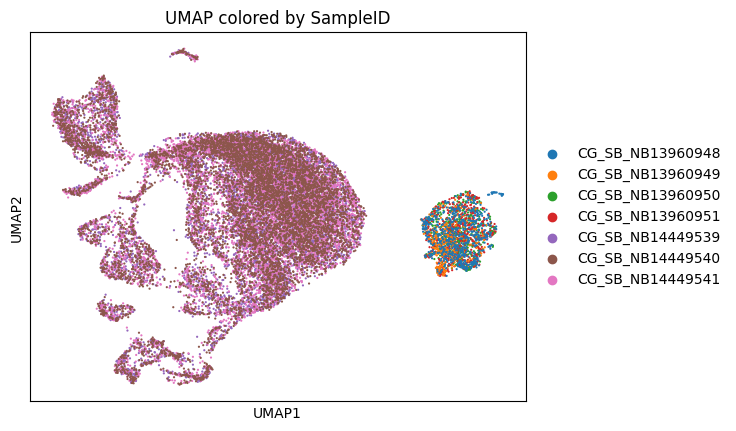

In [14]:
plt.figure(figsize=(10, 8))
sc.pl.umap(adata_filtered, color='SampleID', size=10, title="UMAP colored by SampleID")
plt.show()


In [ ]:
#adata_mlem = sc.read_h5ad(base_dir + "adata_merged_after_scrumblet.h5ad")
#adata_new = sc.read_h5ad(base_dir + "adata_merged_new_env_scrublet.h5ad")

In [ ]:
# Visualize mitochondrial percentage distribution per sample
sns.boxplot(x='SampleID', y='pct_counts_mt', data=adata_scrscvi.obs)
plt.xticks(rotation=90)
plt.title("Mitochondrial Content per Channel")
plt.show()

# Visualize gene count distribution per sample
sns.boxplot(x='SampleID', y='total_counts', data=adata_scrscvi.obs)
plt.xticks(rotation=90)
plt.title("Gene Count per Channel")
plt.show()


In [ ]:
# Group by sample and get summary statistics for QC metrics
qc_summary = adata_scrscvi.obs.groupby('SampleID')[['pct_counts_mt', 'total_counts', 'pct_counts_ribo']].describe()
print(qc_summary)

In [ ]:
print(adata_scrscvi) # how does it look
#print(adata_mlem)
#print(adata_new)

In [ ]:
print(adata_scrscvi.obs.head()) #cells
#print(adata_mlem.obs.head()) #cells
#print(adata_new.obs.head())

In [ ]:
print(adata_scrscvi.var.head())
#print(adata_mlem.var.head())
#print(adata_new.var.head())

In [ ]:
print(adata_scrscvi.shape)  # (n_cells, n_genes
#print(adata_mlem.shape)
#print(adata_new.shape)
type(adata_scrscvi.X) # what type of data is it
#type(adata_mlem.X)
#type(adata_new.X)

In [ ]:
# visualisation of the counts with violin plot
sc.pl.violin(adata_scrscvi, ["n_genes_by_counts", "total_counts"], jitter=0.4)
sc.pl.violin(adata_scrscvi, ["pct_counts_mt_gene", "pct_counts_ribo_gene"], jitter=0.4)
sc.pl.scatter(adata_scrscvi, x="total_counts", y="n_genes_by_counts")

In [ ]:
# Step 1: Run PCA (if you haven't already, as UMAP relies on PCA or other dimensionality reduction)
sc.tl.pca(adata_scrscvi, svd_solver='arpack')

# Step 2: Compute the nearest neighbors graph
sc.pp.neighbors(adata_scrscvi, n_neighbors=15, n_pcs=50)  # n_neighbors can be adjusted

# Step 3: Calculate the UMAP embeddings
sc.tl.umap(adata_scrscvi)

# Step 4: Now you can visualize the UMAP plot with 'scrublet' and 'scrublet_score' colorings
sc.pl.umap(adata_scrscvi, color=["scrublet", "scrublet_score"])

#Step 2: Visualize doublets vs singlets based on library size (total counts)
sc.pl.scatter(adata_scrscvi, x="total_counts", y="n_genes_by_counts", color="scrublet", title="Doublets vs Singlets based on Library Size", palette=["grey", "red"])

# You can also use a UMAP plot if you have UMAP coordinates
sc.pl.umap(adata_scrscvi, color="scrublet", title="Doublets vs Singlets on UMAP")

In [ ]:
sns.histplot(adata_scrscvi.obs["scrublet_score"], bins=50, kde=True)
#sns.histplot(adata_new.obs["scrublet_score"], bins=50, kde=True)
#sns.histplot(adata_mlem.obs["scrublet_score"], bins=50, kde=True)

In [ ]:
# Count occurrences of each category in the 'scrublet' column
doubletscr_counts = adata_scrscvi.obs["scrublet"].value_counts()
doubletscvi_counts = adata_scrscvi.obs["scVI_SOLO"].value_counts()
# Print the count of doublets
print(f"Number of doublets identified: {doubletscr_counts['doublet']}")
print(f"Number of doublets identified: {doubletscvi_counts['doublet']}")

newscr_counts = adata_new.obs["scrublet"].value_counts()
print(f"Number of doublets identified: {newscr_counts['doublet']}")

In [ ]:
print(adata_scrscvi.obs.groupby("scVI_SOLO").size())
print(adata_scrscvi.obs.groupby("scrublet").size())

In [ ]:
sns.histplot(adata_scrscvi.obs["scrublet_score"], bins=50)

In [ ]:
sns.histplot(adata_scrscvi.obs["scVI_SOLO_score"], bins=50)

In [ ]:
sc.pl.umap(adata_scrscvi, color = ["scVI_SOLO_score", "scrublet_score"])

In [ ]:
# Count the number of cells classified as doublets by both methods
doublet_count = ((adata_scrscvi.obs["scVI_SOLO"] == "doublet") & 
                 (adata_scrscvi.obs["scrublet"] == "doublet")).sum()

print(f"Number of cells labeled as doublets by both scVI Solo and Scrublet: {doublet_count}")


In [ ]:
# filtering out doublets as a consensus of both algs
# Filter out cells labeled as doublets by BOTH methods
adata_filtered = adata_scrscvi[~((adata_scrscvi.obs["scVI_SOLO"] == "doublet") & (adata_scrscvi.obs["scrublet"] == "doublet")), :]

# Print the new shape to confirm removal
print(f"Original dataset shape: {adata_scrscvi.shape}")
print(f"Filtered dataset shape: {adata_filtered.shape}")



In [ ]:
# Save filtered dataset (without doublets)
adata.write(base_dir + "adata_merged_scr_scvi_doub_norm.h5ad")

In [ ]:
# Filtering Cells & Genes
sc.pp.filter_cells(adata_filtered, min_genes=200)
sc.pp.filter_genes(adata_filtered, min_cells=3)

In [ ]:
print(adata_filtered.shape)

In [ ]:
adata_filtered = adata_filtered[adata_filtered.obs.n_genes_by_counts > 500, :]  # Remove nuclei with very few genes
adata_filtered = adata_filtered[adata_filtered.obs.total_counts < 100000, :]  # Remove outliers
adata_filtered = adata_filtered[adata_filtered.obs.pct_counts_mt < 5, :]  # Remove cells with >5% mito reads
adata_filtered = adata_filtered[adata_filtered.obs.pct_counts_ribo < 10, :]  # Remove high ribosomal content

# Set thresholds (adjust based on dataset)
min_genes = 200  # Keep cells with at least 200 genes
max_mito = 5     # Remove cells with >5% mitochondrial content

# Filter low-quality cells
adata_filtered = adata_filtered[(adata_filtered.obs.n_genes_by_counts > min_genes) & 
              (adata_filtered.obs.pct_counts_mt < max_mito)]

In [ ]:
#data_filtered = adata_scrscvi[adata_scrscvi.obs.n_genes_by_counts > 500, :]  # Remove nuclei with very few genes
#adata_filtered = adata_filtered[adata_filtered.obs.total_counts < 100000, :]  # Remove outliers
#data_filtered = adata_scrscvi[adata_scrscvi.obs.pct_counts_mt < 10, :]  # Remove cells with >5% mito reads
#adata_filtered = adata_filtered[adata_filtered.obs.pct_counts_ribo < 10, :]  # Remove high ribosomal content

# Set thresholds (adjust based on dataset)
min_genes = 500  # Keep cells with at least 200 genes
max_mito = 10     # Remove cells with >5% mitochondrial content

# Filter low-quality cells
adata_holly = adata_scrscvi[(adata_scrscvi.obs.n_genes_by_counts > min_genes) & 
              (adata_scrscvi.obs.pct_counts_mt < max_mito)]

In [ ]:
print(adata_holly.shape)

In [ ]:
adata.write(base_dir + "adata_merged_scrublet_scvi_umi_cons_doub_soupx_fin.h5ad")

In [ ]:
adata_filtered_harsh = sc.read_h5ad(base_dir + "adata_merged_scr_scvi_nodoub_filt_norm_wo_mtrib.h5ad")
#adata_ded = sc.read_h5ad(base_dir + "adata_merged_scrublet_scvi_nodoublets_filtered.h5ad")

In [ ]:
print(adata_filtered.shape)

In [ ]:
# Normalization & Log Transformation
sc.pp.normalize_total(adata_holly, target_sum=1e4)
sc.pp.log1p(adata_holly)

In [ ]:
# Step 1: PCA (if not already done)
sc.tl.pca(adata_filtered, svd_solver='arpack')

# Step 2: Compute the UMAP embedding
sc.pp.neighbors(adata_filtered, n_neighbors=10, n_pcs=40)  # Adjust n_neighbors and n_pcs as needed
sc.tl.umap(adata_filtered)

# Step 3: Clustering (Optional)
# Perform clustering if you want to group cells, can use Leiden or Louvain clustering
sc.tl.leiden(adata_filtered)  # You can replace with `sc.tl.louvain()` if preferred

# Step 4: Visualize UMAP colored by SampleID
plt.figure(figsize=(10, 8))
sc.pl.umap(adata_filtered, color='SampleID_New', size=10, title="UMAP colored by SampleID")
plt.show()


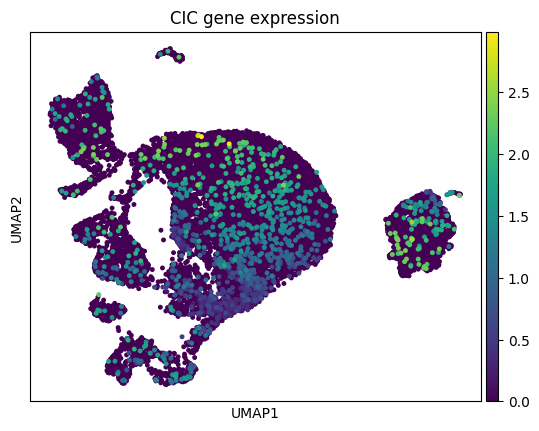

In [32]:
gene = "CIC"  # Replace with the actual gene name

# Make sure the gene exists in the dataset
if gene in adata_filtered.var_names:
        sc.pl.umap(adata_filtered, color=gene, cmap="viridis", size=50, title="CIC gene expression")
else:
    print(f"⚠️ Gene '{gene}' not found in dataset.")

In [ ]:
adata_filt = adata_filt[:, ~(adata_filt.var["mt_gene"] | adata_filt.var["ribo_gene"])].copy()
adata_filtered_harsh = adata_filtered_harsh[:, ~(adata_filtered_harsh.var["mt_gene"] | adata_filtered_harsh.var["ribo_gene"])].copy()

In [ ]:
adata_filt.write(base_dir + "adata_merged_scr_scvi_nodoub_filt_norm_wo_mtrib.h5ad")
adata_filtered_harsh.write(base_dir + "adata_merged_scr_scvi_nodoub_filtscvi_norm_wo_mtrib.h5ad")

In [24]:
# Define two groups based on SampleID or another metadata column
group1_samples = ["CG_SB_NB14449539", "CG_SB_NB14449540", "CG_SB_NB14449541"]  # Modify based on your dataset
group2_samples = ["CG_SB_NB13960948", "CG_SB_NB13960950", "CG_SB_NB13960951"]

# Create separate AnnData objects for each group
adata_group1 = adata_filtered[adata_filtered.obs["SampleID"].isin(group1_samples)].copy()
adata_group2 = adata_filtered[adata_filtered.obs["SampleID"].isin(group2_samples)].copy()

# Perform highly variable gene selection separately for each group
sc.pp.highly_variable_genes(adata_group1, flavor="seurat_v3", n_top_genes=20000)
sc.pp.highly_variable_genes(adata_group2, flavor="seurat_v3", n_top_genes=20000)

# Retrieve the highly variable genes
hvg_group1 = adata_group1.var[adata_group1.var["highly_variable"]].index
hvg_group2 = adata_group2.var[adata_group2.var["highly_variable"]].index

# Find shared HVGs
shared_hvg = set(hvg_group1).intersection(set(hvg_group2))

# Print summary
print(f"Number of highly variable genes in Group 1: {len(hvg_group1)}")
print(f"Number of highly variable genes in Group 2: {len(hvg_group2)}")
print(f"Number of shared highly variable genes: {len(shared_hvg)}")


/software/cellgen/team274/lr26/miniforge3/envs/my-python/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Number of highly variable genes in Group 1: 20000
Number of highly variable genes in Group 2: 20000
Number of shared highly variable genes: 14240


/software/cellgen/team274/lr26/miniforge3/envs/my-python/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [ ]:
# Create separate AnnData objects for each group
adata_group_1 = adata_filt[adata_filt.obs["SampleID"].isin(group1_samples)].copy()
adata_group_2 = adata_filt[adata_filt.obs["SampleID"].isin(group2_samples)].copy()

# Perform highly variable gene selection separately for each group
sc.pp.highly_variable_genes(adata_group_1, flavor="seurat_v3", n_top_genes=20000)
sc.pp.highly_variable_genes(adata_group_2, flavor="seurat_v3", n_top_genes=20000)

# Retrieve the highly variable genes
hvg_group_1 = adata_group_1.var[adata_group_1.var["highly_variable"]].index
hvg_group_2 = adata_group_2.var[adata_group_2.var["highly_variable"]].index

# Find shared HVGs
shared_hvg_0 = set(hvg_group_1).intersection(set(hvg_group_2))

# Print summary
print(f"Number of highly variable genes in Group 1: {len(hvg_group_1)}")
print(f"Number of highly variable genes in Group 2: {len(hvg_group_2)}")
print(f"Number of shared highly variable genes: {len(shared_hvg_0)}")


In [26]:
shared_hvg = set(hvg_group1).intersection(set(hvg_group2))
adata_hvg_shared = adata_filtered[:, list(shared_hvg)].copy()
#adata_hvg_shared.write(base_dir + "adata_merged_scrublet_scvi_nodoublets_filtered_norm_umi_shared_hvgs30k_wo_mtrib.h5ad")

In [27]:
all_hvg = set(hvg_group1).union(set(hvg_group2))
all_hvg = adata_filtered[:, list(all_hvg)].copy()
#all_hvg.write(base_dir + "adata_merged_scrublet_scvi_nodoublets_filtered_norm_umi_all_hvgs30k_wo_mtrib.h5ad")

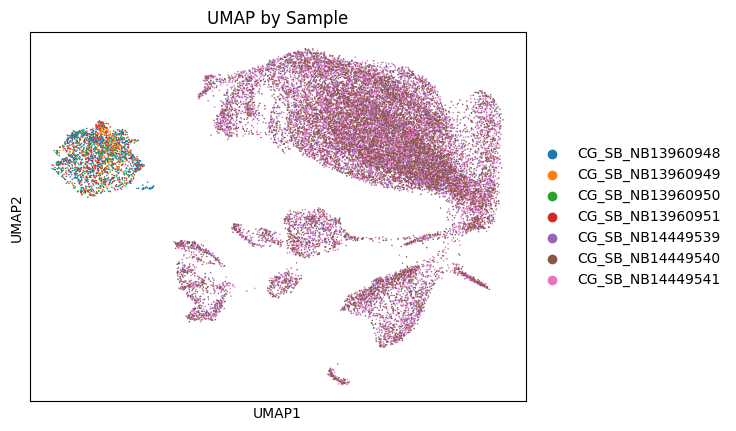

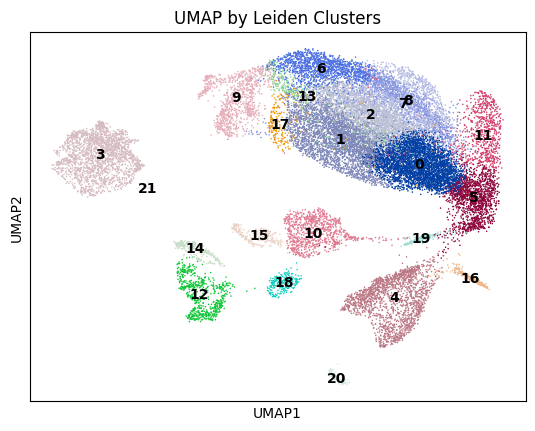

In [31]:
adata_hvg_shared = adata_filtered[:, list(shared_hvg)].copy()

#adata_filtered = adata_filtered[:, list(all_hvg)].copy()  # Use only shared HVGs
sc.tl.pca(adata_hvg_shared)
sc.pp.neighbors(adata_hvg_shared)
sc.tl.umap(adata_hvg_shared)
sc.tl.leiden(adata_hvg_shared)

# UMAP colored by SampleID
sc.pl.umap(adata_hvg_shared, color="SampleID", title="UMAP by Sample")

# UMAP colored by Leiden Clusters
sc.pl.umap(adata_hvg_shared, color="leiden", title="UMAP by Leiden Clusters", legend_loc="on data")


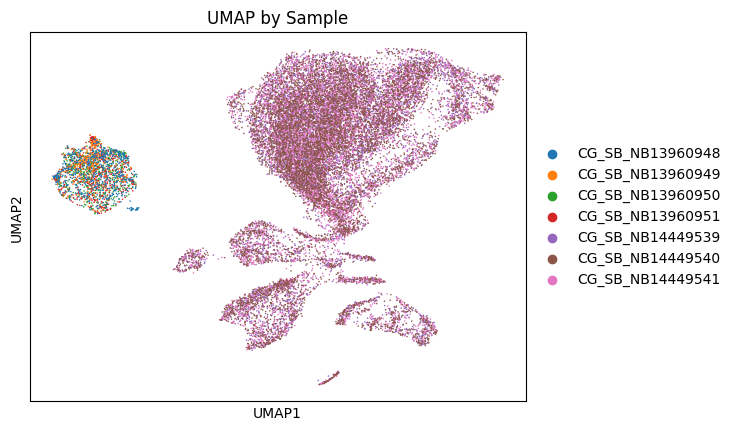

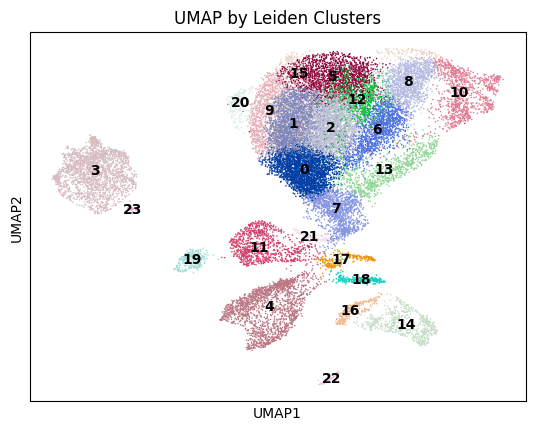

In [29]:
all_hvg = set(hvg_group1).union(set(hvg_group2))
all_hvg = adata_filtered[:, list(all_hvg)].copy()
sc.tl.pca(all_hvg)
sc.pp.neighbors(all_hvg)
sc.tl.umap(all_hvg)
sc.tl.leiden(all_hvg)

# UMAP colored by SampleID
sc.pl.umap(all_hvg, color="SampleID", title="UMAP by Sample")

# UMAP colored by Leiden Clusters
sc.pl.umap(all_hvg, color="leiden", title="UMAP by Leiden Clusters", legend_loc="on data")

In [30]:
gene = "DUX4"  # Replace with the actual gene name

# Make sure the gene exists in the dataset
if gene in all_hvg.var_names:
        sc.pl.umap(all_hvg, color=gene, cmap="viridis", size=50, title="DUX4 gene expression")
else:
    print(f"⚠️ Gene '{gene}' not found in dataset.")

⚠️ Gene 'DUX4' not found in dataset.


In [ ]:
# Subset the original dataset using unique HVGs for each group
adata_group1_hvg = adata_group1[:, hvg_group1].copy()
adata_group2_hvg = adata_group2[:, hvg_group2].copy()

# Group 1 UMAP and Clustering
sc.tl.pca(adata_group1_hvg)
sc.pp.neighbors(adata_group1_hvg)
sc.tl.umap(adata_group1_hvg)
sc.tl.leiden(adata_group1_hvg, resolution=1.0)  # Adjust resolution as needed

# Group 2 UMAP and Clustering
sc.tl.pca(adata_group2_hvg)
sc.pp.neighbors(adata_group2_hvg)
sc.tl.umap(adata_group2_hvg)
sc.tl.leiden(adata_group2_hvg, resolution=1.0)

In [ ]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Group 1 UMAP
sc.pl.umap(adata_group1_hvg, color="leiden", title="Pre-treatment FT samples UMAP", ax=axes[0], show=False)

# Plot Group 2 UMAP
sc.pl.umap(adata_group2_hvg, color="leiden", title="Post-treatment FO samples UMAP", ax=axes[1], show=False)

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
gene = "CD99"  # Replace with the actual gene name

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

if gene in all_hvg.var_names:
        sc.pl.umap(adata_group1_hvg, color=gene, cmap="viridis", size=20, title=f"Gene '{gene}' expression", ax=axes[0], show=False)
        sc.pl.umap(adata_group2_hvg, color=gene, cmap="viridis", size=20, title=f"Gene '{gene}' expression", ax=axes[1], show=False)
        plt.tight_layout()
        plt.show()

else:
    print(f"⚠️ Gene '{gene}' not found in dataset.")

In [ ]:
# Group 1 marker genes
sc.tl.rank_genes_groups(adata_group1_hvg, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_group1_hvg, n_genes=10, sharey=False)

# Group 2 marker genes
sc.tl.rank_genes_groups(adata_group2_hvg, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_group2_hvg, n_genes=10, sharey=False)

In [ ]:
#sc.pl.rank_genes_groups_heatmap(adata_group1_hvg, n_genes=5, groupby="leiden", cmap="viridis")
sc.pl.rank_genes_groups_heatmap(adata_group2_hvg, n_genes=10, groupby="leiden", cmap="viridis")

In [ ]:
# Convert marker genes to a DataFrame
marker_genes_pre = pd.DataFrame(adata_group1_hvg.uns["rank_genes_groups"]["names"]).head(10)
marker_genes_post = pd.DataFrame(adata_group2_hvg.uns["rank_genes_groups"]["names"]).head(10)

# Save to CSV
marker_genes_pre.to_csv("marker_genes_pre_nomtrib-consfilt-res1.csv", index=False)
marker_genes_post.to_csv("marker_genes_post_nomtrib-consfilt-res1.csv", index=False)

In [ ]:
# Identify mitochondrial genes (assuming they are annotated in `var` as "mt_gene")
adata_group1 = adata_group1[:, ~adata_group1.var["mt_gene"]].copy()
adata_group2 = adata_group2[:, ~adata_group2.var["mt_gene"]].copy()

# Now compute HVGs
sc.pp.highly_variable_genes(adata_group1, flavor="seurat_v3", n_top_genes=2000)
sc.pp.highly_variable_genes(adata_group2, flavor="seurat_v3", n_top_genes=2000)

In [ ]:
hvg_group1 = adata_group1.var[adata_group1.var["highly_variable"]].index
hvg_group2 = adata_group2.var[adata_group2.var["highly_variable"]].index

In [ ]:
adata_group1_hvg.write(base_dir + "adata_merged_scrublet_scvi_nodoublets_filtered_norm_holly_2000_pretreatment_womt.h5ad")
adata_group2_hvg.write(base_dir + "adata_merged_scrublet_scvi_nodoublets_filtered_norm_holly_2000_posttreatment_womt.h5ad")

In [ ]:
adata_gr1 = sc.read_h5ad(base_dir + "adata_merged_scrublet_scvi_nodoublets_filtered_norm_holly_2000_pretreatment_womt.h5ad")
adata_gr2 = sc.read_h5ad(base_dir + "adata_merged_scrublet_scvi_nodoublets_filtered_norm_holly_2000_posttreatment_womt.h5ad")

In [ ]:
print(adata_gr1) # how does it look
print(adata_gr1.obs.head()) #cells
print(adata_gr1.var.head())
print(adata_gr1.shape)  # (n_cells, n_genes)
type(adata_gr1.X) # what type of data is it

In [ ]:
import scanpy as sc
import celltypist

# Download a pre-trained model (optional if you haven't downloaded it yet)
celltypist.models.download_models(force_update=True)

# Load the pre-trained model for annotation (for example, "Adult_Human_Skin.pkl")
model = celltypist.models.Model.load('Human_Lung_Atlas.pkl')

# Perform annotation using the model
predictions = celltypist.annotate(adata_group1_hvg, model=model, majority_voting=True)

# Extract predicted labels
predicted_cell_types = predictions.predicted_labels  # or predictions.majority_voting

# Check column names in predicted labels
print(predictions.predicted_labels.head())

# Assign the correct column to AnnData
adata_group1_hvg.obs['predicted_cell_type'] = predictions.predicted_labels['majority_voting']

# Plot UMAP with predicted cell types
sc.pl.umap(adata_group1_hvg, color='predicted_cell_type', title='Cell Type Prediction')


In [ ]:
adata_holly.write(base_dir + "adata_merged_scrublet_scvi_nodoublets_filtered_norm_holly.h5ad")

In [ ]:
# Identify Highly Variable Genes
sc.pp.highly_variable_genes(adata_dedoubl, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_variable = adata_dedoubl[:, adata_dedoubl.var.highly_variable]
sc.pp.scale(adata_variable, max_value=10)

In [ ]:
# Scaling & PCA
sc.tl.pca(adata_var, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_var, log=True)

In [ ]:
# Clustering & UMAP Embedding
sc.pp.neighbors(adata_var, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_var)
sc.tl.leiden(adata_var, resolution=0.3, flavor="igraph", directed=False, n_iterations=2)
adata_var.obs["leiden"].nunique()

#sc.pl.umap(adata_var, color=['leiden'])